## Задание: (10 баллов)

Напишите класс, который реализует автоматическую трансформацию числовых колонок произвольного датафрейма в распределения,
    похожие на нормальные, после чего нормализует (см. семинар по предобработке). Класс должен автоматически для каждой колонки обучающей выборки (метод `fit`) определять, какая именно трансформация ей требуется, чтобы "превратиться в нормальную". Далее, в методе `transform` класс производит все необходимые трансформации + нормализацию для произвольной выборки. Ваш класс в рамках этого задания должен уметь работать со следующими распределениями:
- похожее на нормальное (только нормализация)
- мультимодальное (только нормализация)
- скошенное влево (обычно и сильно)
- скошенное вправо (обычно и сильно)
- равномерное
- "категориальное" (см. аргумент `cat_thr`)

Старайтесь подбирать трансформации из элементарных функций. Вы можете спрашивать LLM, как отличить одно распределение от другого. Вам пригодятся различные статистические показатели/тесты, в которые вы еще не проходили, но такова жизнь. Вы также можете попросить LLM написать вам этот класс, однако не ждите, что он будет работать хорошо с первого раза, придется дебажить каждый конкретный случай. Для написания кода рекомендую Qwen-Coder.

В файле `distributions.csv` лежат данные каждого типа, чтобы проверить себя. При сдаче работы выведите в левом столбике оригинальные данные (обычная и лог шкалы), а в правом -- после трансформации + нормализации (с флагом `use_quantile_transformer=False`), аналогично тому, как мы делали на семинаре. Без визуализации вы получите 0 баллов. Задание будет оцениваться субъективно на похожесть на нормальное распределение. За излишнее использование QuantileTransformer буду штрафовать. Пишите читаемый и аккуратный код. Удачи!

Шаблон с указанием необходимых параметров на вход (свои добавлять можно):

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import seaborn as sns
import sys
from scipy import stats
sys.path.append('/home/boris/projects/aimasters/1sem/ML1/utils')
from utils import get_split, train_linear_model, get_df_info_mine, get_df_info, plot_density, compare_transformation_dist
import matplotlib.pyplot as plt


In [271]:
class FeatureTransformer:
    def __init__(self, scaler='StandardScaler', use_quantile_transformer=False, cat_thr=10, *args, **kwargs):
        '''
        scaler: str in ('StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler') or None
            -- вариант нормализации данных после трансформаций. None -- без нормализации.

        use_quantile_transformer: Если True, то в случаях, когда мы затрудняемся определить подходящую трансформацию из элементарных функций,
            используем sklearn.preprocessing.QuantileTransformer. Если False, то для таких колонок не используем трансформацию.

        cat_thr: если в колонке количество уникальных значений < cat_thr,
            мы ее считаем за категориальную и не трансформируем (нормализацию делаем)
        '''
        match scaler:
            case 'StandardScaler':
                self.scaler = StandardScaler()
            case 'MinMaxScaler':
                self.scaler = MinMaxScaler()
            case 'MaxAbsScaler':
                self.scaler = MaxAbsScaler()
            case 'RobustScaler':
                self.scaler = RobustScaler()
            case _:
                self.scaler = None
        self.use_quantile_transformer = use_quantile_transformer
        self.transfrom_dict = {
            'yeo-johnson': lambda x: PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(x.reshape(-1, 1))[:, 0],
            'np.log': np.log,
            'np.log1p': np.log1p,
            'x/(x + 1)': lambda x: x / (x + 1),
            'x/(x - min)': lambda x: x / (x - np.min(x)+1),
            'x**1/3': lambda x: x**1/3,
            'x**3': lambda x: x**3,
            'placebo': lambda x: x,
        }
        self.cat_thr = cat_thr
        self.transformers_ = {}
        self.distribution_types_ = {}
        self.transformer_names_ = {}

        pass

    def _detect_distribution_type(self, series):
        """Определяет тип распределения колонки"""
        # Удаляем NaN значения
        if len(series) < 10:
            return 'unknown'
        # Проверка на категориальное распределение
        unique_ratio = len(series.unique()) / len(series)
        if unique_ratio < 0.1 or len(series.unique()) <= self.cat_thr:
            return 'categorical'
        # Считаем скошенность
        # Положительная скошенность означает скошенность влево, негативная скошенность означает скошенность вправо
        # Чем больше модуль скошенности, тем больше скошенность
        skewness = stats.skew(series)
        if skewness > 0.4:
            if skewness > 1:
                return 'strong_left_skew'
            else:
                return 'left_skew'
        elif skewness < -0.4:
            if skewness < -1:
                return 'strong_right_skew'
            else:
                return 'right_skew'
        # Проверка на нормальность и равномерность тестом Колмогорова-Смирнова
        p_norm = stats.kstest(series, "norm", args = (np.mean(series), np.std(series))).pvalue
        p_uniform = stats.kstest(series, "uniform", args = (np.min(series), np.max(series) - np.min(series))).pvalue
        # Если принимаются обе нулевые гипотезы, выбираем большее p-valuee
        if p_uniform > 0.05:
            return 'uniform'
        elif p_norm > 0.05:
            return 'normal'
        else:
            return 'unknown'
        # if p_norm > 0.05 and p_uniform > 0.05:
        #     if p_norm > p_uniform:
        #         return 'normal'
        #     else:
        #         return 'uniform'
        # # Если принимается только одна нулевая гипотеза, выбираем ее
        # elif p_norm < 0.05 and p_uniform > 0.05:
        #     return 'uniform'
        # elif p_norm > 0.05 and p_uniform < 0.05:
        #     return 'normal'
        # else:
        #     return 'unknown'
        
    def _get_transformer_for_type(self, distribution_type):
        match distribution_type:
            case 'unknown':
                return 'placebo'
            case 'categorical':
                return 'placebo'
            case 'normal':
                return 'placebo'
            case 'uniform':
                return 'yeo-johnson'
            case 'left_skew':
                return 'np.log'
            case 'right_skew':
                return 'x/(x - min)'
            case 'strong_left_skew':
                return 'np.log'
            case 'strong_right_skew':
                return 'yeo-johnson'
            
    def fit(self, X, *args, **kwargs):
        '''
        "Обучаем" наш трансформатор -- собираем все необходимые данные на обучающей выборке, напр. mean, std для StandardScaler,
            а также "записываем", какую трансформацию нужно применить к каждой колонке
        '''
        self._X_sample = X.sample(200)
        # Работаем только с числовыми колонками
        cols = X.select_dtypes(include=[np.number]).columns
        for col in cols:
            distribution_type = self._detect_distribution_type(self._X_sample[col])
            self.distribution_types_[col] = distribution_type
            
            if self.use_quantile_transformer:
                # Используем QuantileTransformer как универсальное решение
                transformer = QuantileTransformer(output_distribution='normal', random_state=42)
            else:
                # Подбираем трансформацию в зависимости от типа распределения
                transformer = self.transfrom_dict[self._get_transformer_for_type(distribution_type)]
                self.transformer_names_[col] = self._get_transformer_for_type(distribution_type)
            self.transformers_[col] = transformer
        pass
        return self


    def transform(self, X, *args, **kwargs):
        '''
        Применяем "записанные" трансформации + нормализацию на все необходимые колонки

        returns:
            X_transformed -- датафрейм размерности X, где все числовые колонки трансформированы (если надо) (+ нормализованы)
        '''
        X_transformed = pd.DataFrame()
        for col in X.columns:
            X_transformed[col] = self.transformers_[col](X[col].values)
        X_transformed = pd.DataFrame(self.scaler.fit_transform(X_transformed), columns=X.columns)
        self.plot_comparison(X, X_transformed)
        return X_transformed


    def fit_transform(self, X, **fit_kwargs):
        return self.fit(X, **fit_kwargs).transform(X)
    
    def plot_comparison(self, X_original, X_transformed, cols=None, figsize=(15, 10)):
        """
        Визуальное сравнение оригинальных и трансформированных распределений.
        
        Parameters:
        -----------
        X_original : DataFrame
            Оригинальные данные
        X_transformed : DataFrame
            Трансформированные данные
        cols : list, optional
            Список колонок для визуализации (по умолчанию все числовые)
        figsize : tuple, default=(15, 10)
            Размер фигуры
        """
        if cols is None:
            cols = X_original.select_dtypes(include=[np.number]).columns
        for col in cols:
            fig, ax = plt.subplots(1, 4, figsize=(12, 2))
            ax[0].hist(X_original[col], bins=33)
            ax[1].hist(X_original[col], bins=33)
            ax[2].hist(X_transformed[col], bins=33, color='red')
            ax[3].hist(X_transformed[col], bins=33, color='red')
            ax[0].set_title(col)
            ax[1].set_title(self.distribution_types_[col])
            ax[2].set_title(self.transformer_names_[col])
            ax[1].set_yscale('log')
            ax[3].set_yscale('log')
            fig.tight_layout()
            plt.show()
        
        pass

    def print_distribution_types(self,X):
        X_sample = self._X_sample
        for col in X.columns:
            distribution_type = self._detect_distribution_type(X_sample[col])
            print(f"{col}: {distribution_type}")


transform_func = FeatureTransformer(scaler='MinMaxScaler', use_quantile_transformer=False, cat_thr=10)

In [264]:
df = pd.read_csv("distributions.csv")

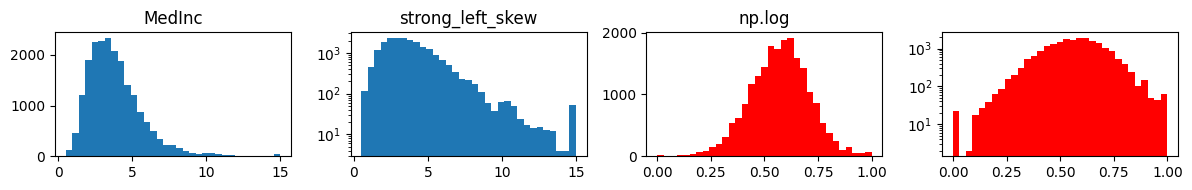

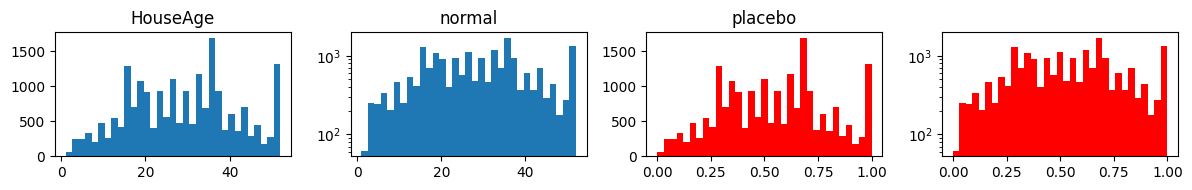

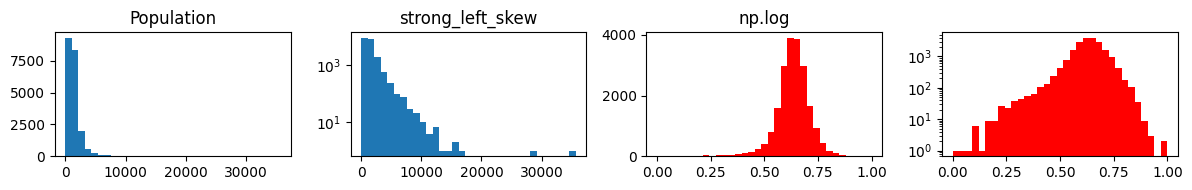

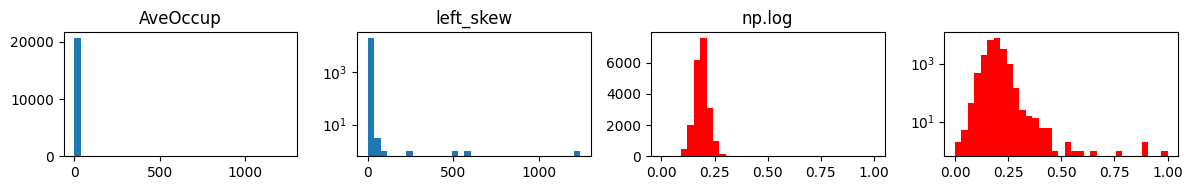

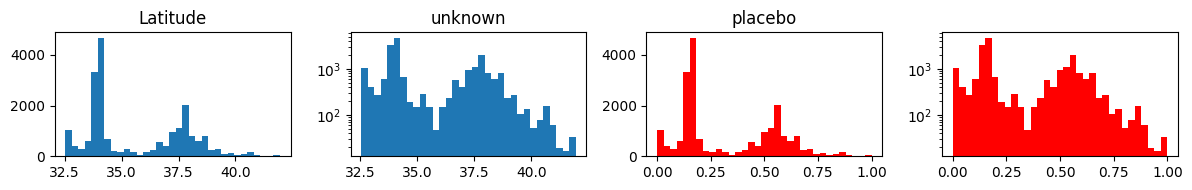

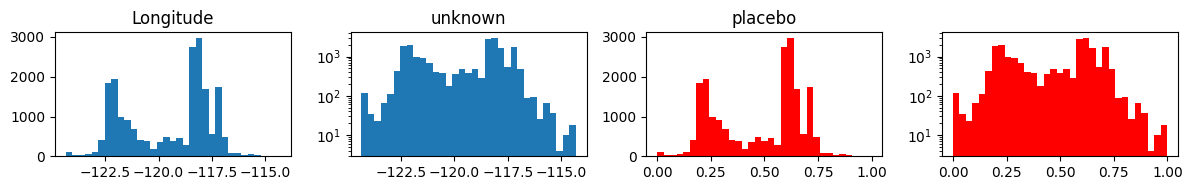

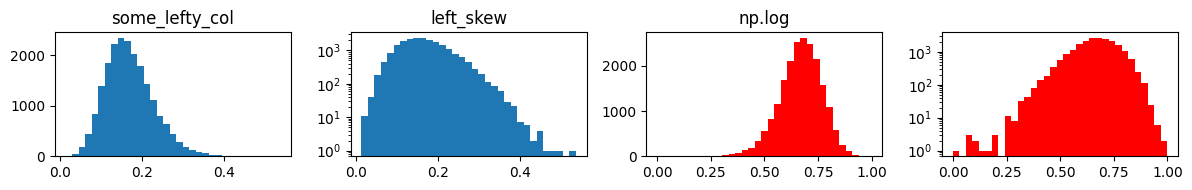

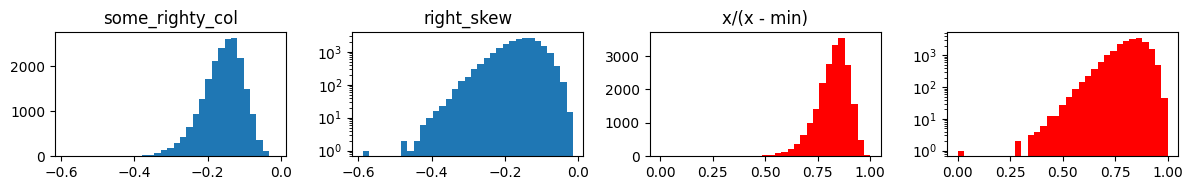

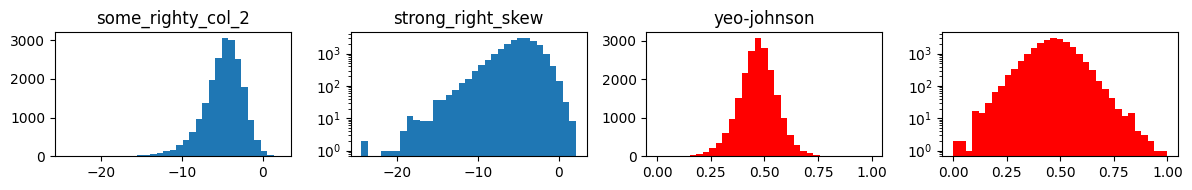

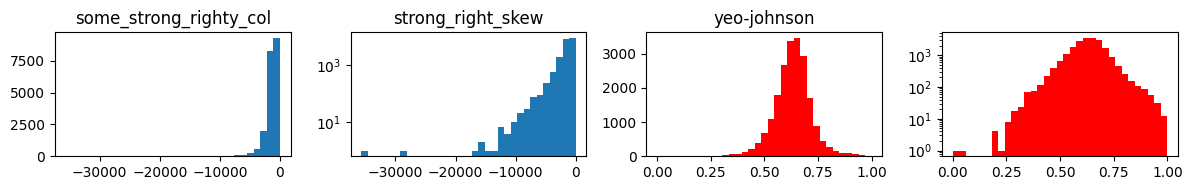

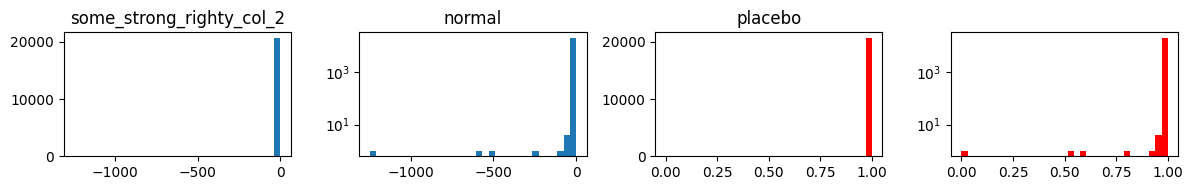

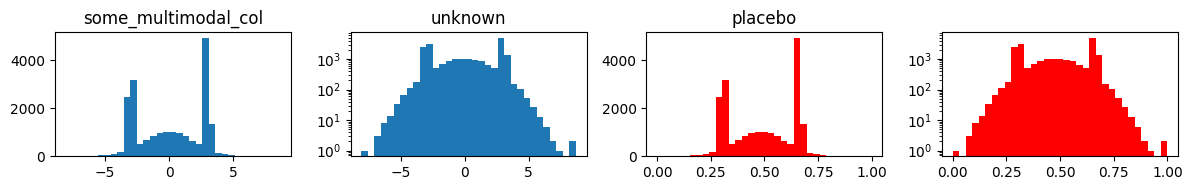

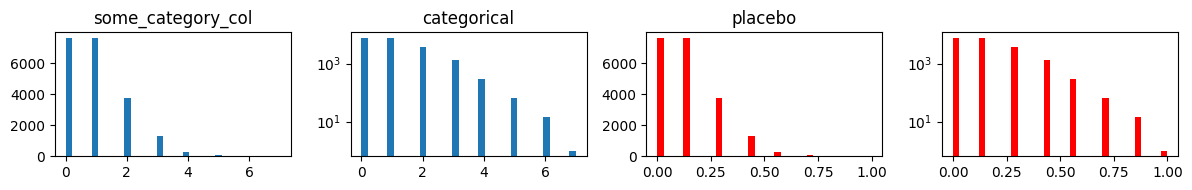

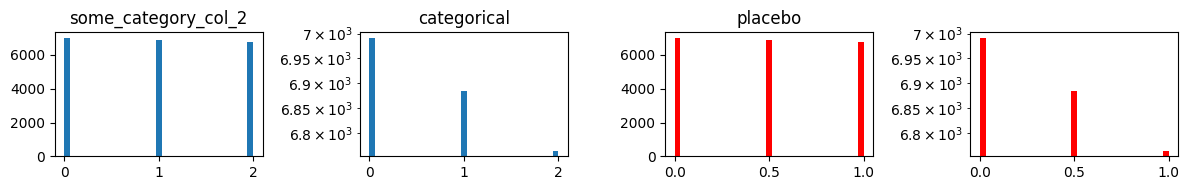

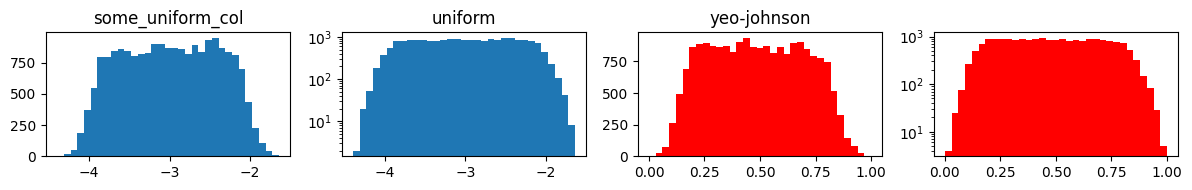

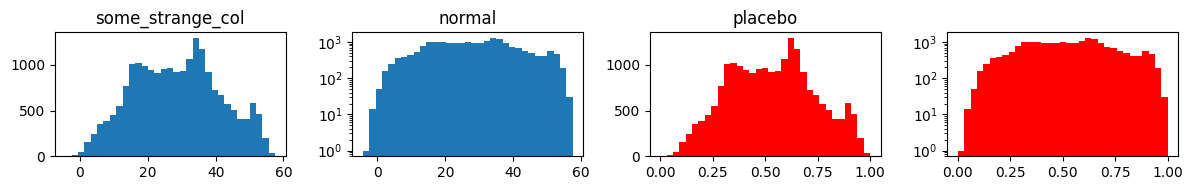

MedInc: strong_left_skew
HouseAge: normal
Population: strong_left_skew
AveOccup: left_skew
Latitude: unknown
Longitude: unknown
some_lefty_col: left_skew
some_righty_col: right_skew
some_righty_col_2: strong_right_skew
some_strong_righty_col: strong_right_skew
some_strong_righty_col_2: normal
some_multimodal_col: unknown
some_category_col: categorical
some_category_col_2: categorical
some_uniform_col: uniform
some_strange_col: normal


In [272]:

transform_func.fit_transform(df)
transform_func.print_distribution_types(df)

# Исследования критериев совпадения распределений
Для выделения нормальных и равномерных распределений использовался критерий Колмогорава-Смирнова. Его проблемой оказалось то, что чем больше sample_size выборки, тем меньше p-value. Побороть это не удалось, поэтому использую сэмпл по 200 значений для определения распределений. p-value убывает экспоненциально с ростом размера выборки.

In [204]:
skewed_cols = {"some_lefty_col", "some_righty_col", "some_strong_righty_col", "some_strong_righty_col_2"}

cols = df.columns
skews = stats.skew(df[cols])

hue = None
df_sample = df.sample(200)

In [92]:
transfrom_dict = {
            'yeo-johnson': lambda x: PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(x.reshape(-1, 1))[:, 0],
            'np.log': np.log,
            'np.log1p': np.log1p,
            'x/(x + 1)': lambda x: x / (x + 1),
            'np.sqrt': np.sqrt,
            'x**3': lambda x: x**3,
            'placebo': lambda x: x,
        }
print(transfrom_dict['placebo'])

<function <lambda> at 0x7fe7537c91c0>


In [222]:
distribution = "uniform"
df_sample = df.sample(200)
# p_norm = stats.kstest(df, "norm", axis = 0, args = (np.mean(df, axis = 0), np.std(df))).pvalue
for col in df_sample.columns:
    unique_ratio = len(df_sample[col].unique()) / len(df_sample[col])
    skew = stats.skew(df_sample[col])
    p_norm = stats.kstest(df_sample[col], "norm", args = (np.median(df_sample[col]), np.std(df_sample[col]))).pvalue
    p_norm_2 = stats.kstest(df_sample[col], "norm", args = (np.mean(df_sample[col]), np.std(df_sample[col]))).pvalue
    p_uniform = stats.kstest(df_sample[col], "uniform", args = (np.min(df_sample[col]), np.max(df_sample[col]) - np.min(df_sample[col]))).pvalue
    # print(f"Column: {col}, p_norm: {p_norm}, p_uniform: {p_uniform}, skew: {skew}, unique_ratio: {unique_ratio}")
    print(f"Column: {col}, p_norm_median: {p_norm}, p_norm_mean: {p_norm_2}, p_uniform: {p_uniform}, skew: {skew}, unique_ratio: {unique_ratio}")


Column: MedInc, p_norm_median: 0.0028202441648910235, p_norm_mean: 0.08287143322701174, p_uniform: 3.241156392607296e-59, skew: 2.0165286411665098, unique_ratio: 0.975
Column: HouseAge, p_norm_median: 0.011439906896236378, p_norm_mean: 0.02717788338103133, p_uniform: 0.03411035080315372, skew: 0.3552341097827989, unique_ratio: 0.23
Column: Population, p_norm_median: 0.009801829660267845, p_norm_mean: 0.01431129951218863, p_uniform: 9.751968784746619e-40, skew: 1.4946272786699095, unique_ratio: 0.96
Column: AveOccup, p_norm_median: 0.47384516643308283, p_norm_mean: 0.30839411859237864, p_uniform: 3.019001429882749e-14, skew: 0.6056175900677261, unique_ratio: 1.0
Column: Latitude, p_norm_median: 1.3225830499104983e-13, p_norm_mean: 6.544766667809081e-11, p_uniform: 1.138640999359479e-19, skew: 0.4246308130039591, unique_ratio: 0.725
Column: Longitude, p_norm_median: 1.053068522090228e-09, p_norm_mean: 3.44536692911792e-10, p_uniform: 7.104615762865396e-09, skew: -0.36066879499659643, uni

/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/scipy/stats/_hypotests.py:397: RuntimeWarning: overflow encountered in scalar multiply
  e3 = 2 * (m + 2) * gamma(k + 3/2) * _ed3((4 * k + 5) / sx) / (12 * y2)
/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/scipy/stats/_hypotests.py:395: RuntimeWarning: overflow encountered in scalar multiply
  e1 = m * gamma(k + 1/2) * _ed2((4 * k + 3)/sx) / (9 * y1)
/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/scipy/stats/_hypotests.py:398: RuntimeWarning: overflow encountered in scalar multiply
  e4 = 7 * m * gamma(k + 1/2) * _ed2((4 * k + 1) / sx) / (144 * y1)
/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/scipy/stats/_hypotests.py:399: RuntimeWarning: overflow encountered in scalar multiply
  e5 = 7 * m * gamma(k + 1/2) * _ed2((4 * k + 5) / sx) / (144 * y1)
/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-package

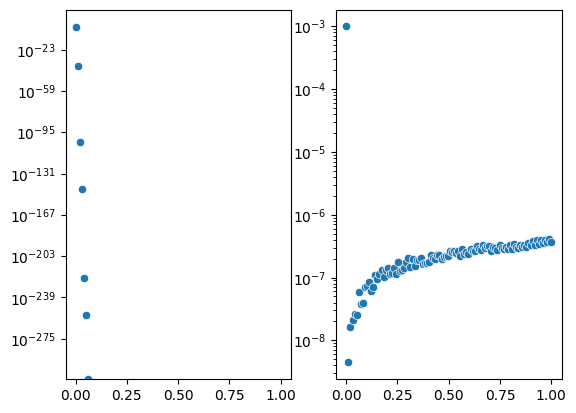

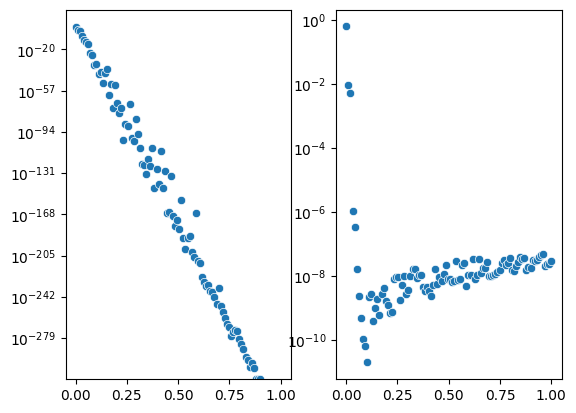

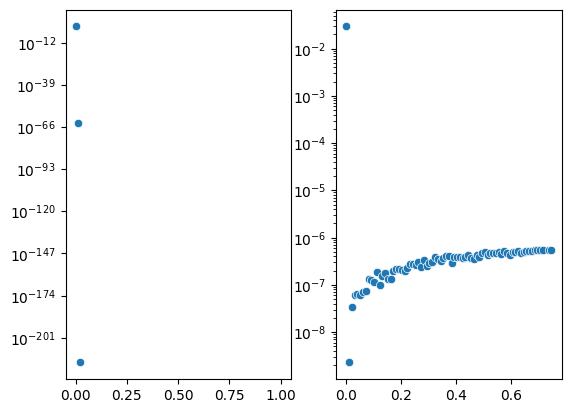

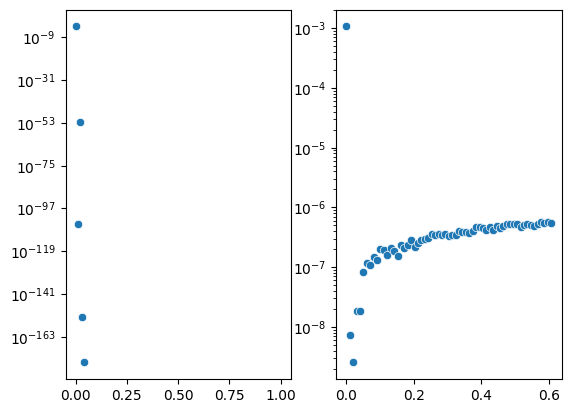

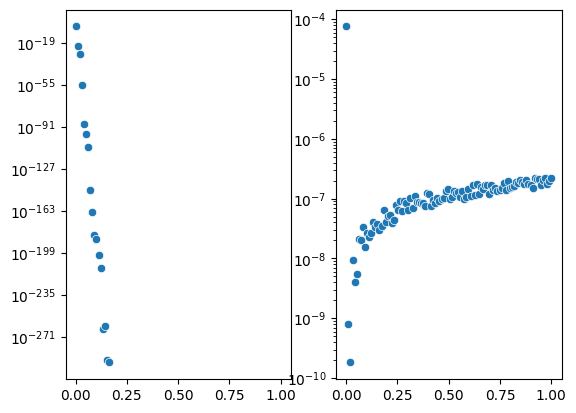

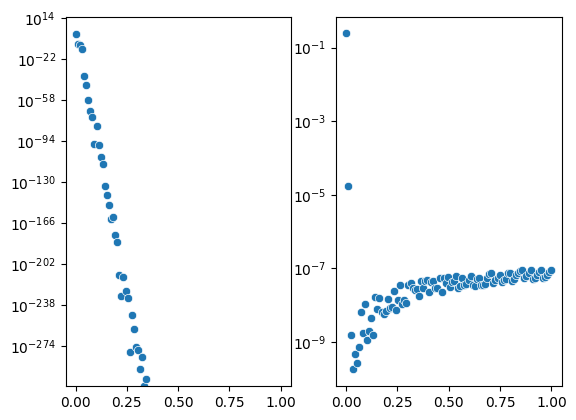

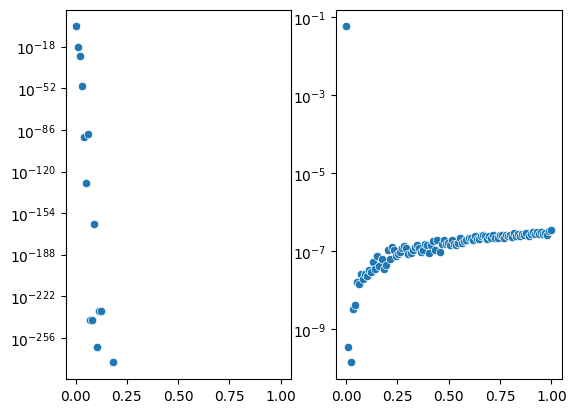

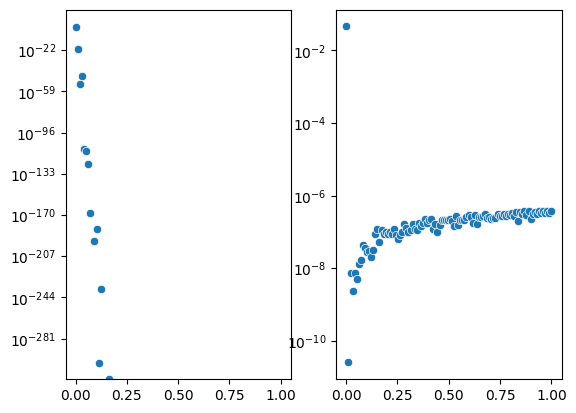

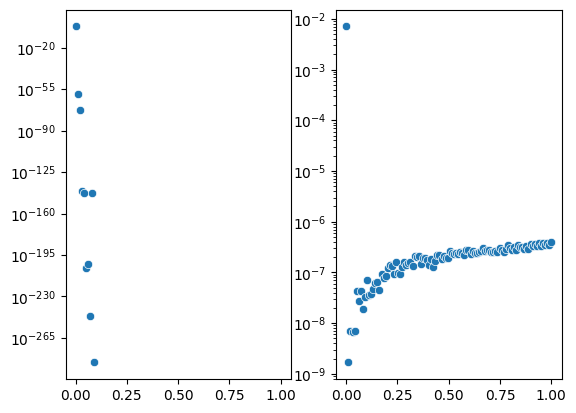

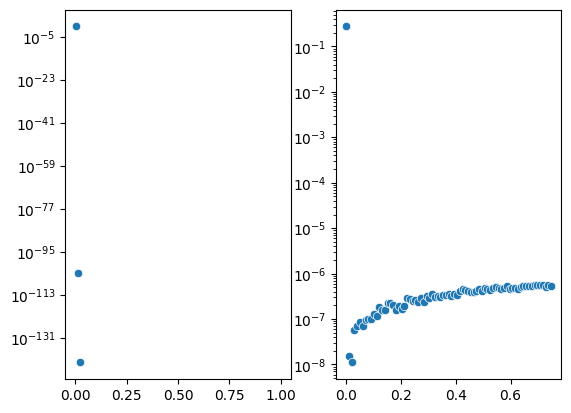

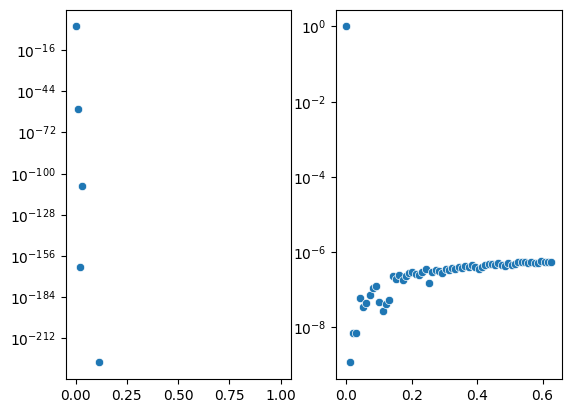

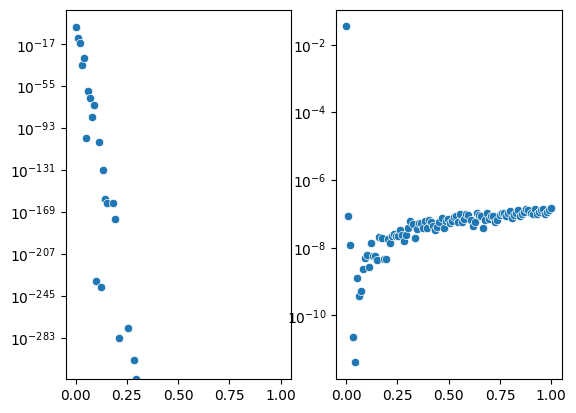

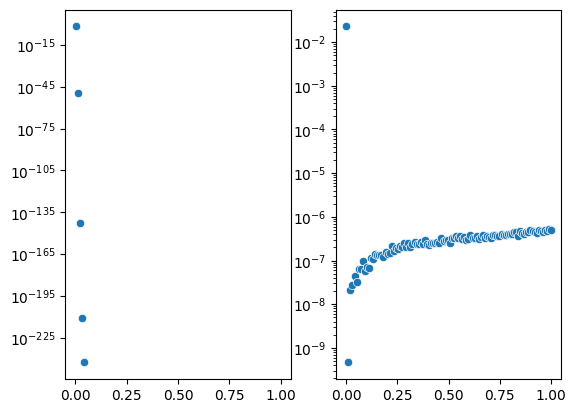

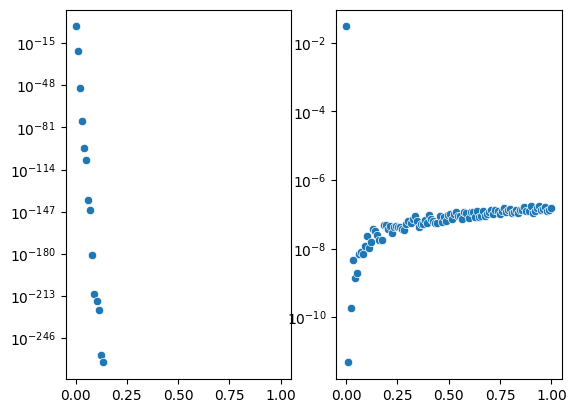

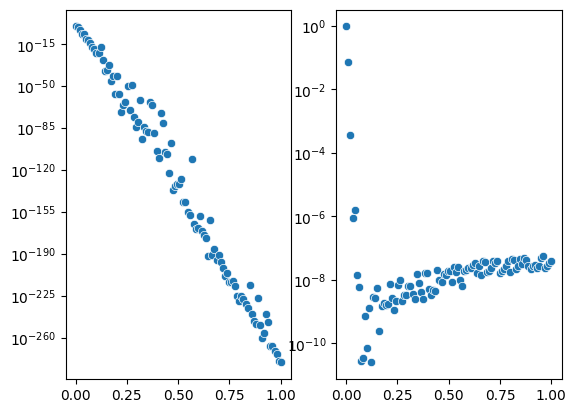

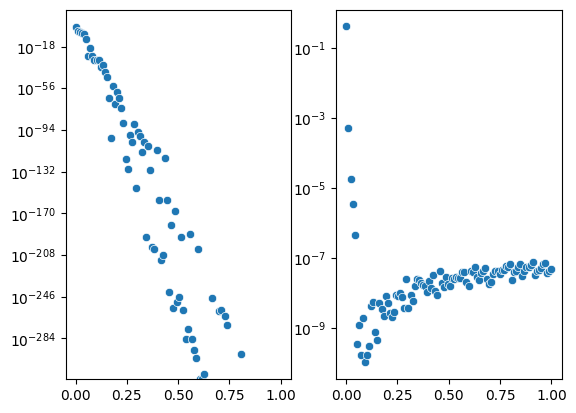

In [248]:
sample_ratios = np.linspace(0.001, 1, 100)
distribution = 'uniform'
for col in df.columns:
    p_values = []
    p_values_adjusted = []  
    for sample_ratio in sample_ratios:
        sample_size = int(df.shape[0] * sample_ratio)
        # print(f"Sample ratio: {sample_ratio}, sample size: {sample_size}")
        df_sample = df.sample(sample_size)
        p_uniform = stats.kstest(df_sample[col], distribution, args = (np.min(df_sample[col]), np.max(df_sample[col]) - np.min(df_sample[col]))).pvalue
        p_uniform_2 = stats.cramervonmises(df_sample[col], distribution, args = (np.min(df_sample[col]), np.max(df_sample[col]) - np.min(df_sample[col]))).pvalue
        p_values.append(p_uniform)
        p_values_adjusted.append(p_uniform_2)
        # print(f"p-values:{p_uniform}, {p_uniform_2}")
    fig, ax = plt.subplots(1,2)
    sns.scatterplot(x = sample_ratios, y = p_values, ax = ax[0])
    sns.scatterplot(x = sample_ratios, y = p_values_adjusted, ax = ax[1])
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')


In [148]:
display(df_sample)
StandardScaler().fit_transform(df_sample)
display(df_sample)

,MedInc,HouseAge,Population,AveOccup,Latitude,Longitude,some_lefty_col,some_righty_col,some_righty_col_2,some_strong_righty_col,some_strong_righty_col_2,some_multimodal_col,some_category_col,some_category_col_2,some_uniform_col,some_strange_col
19933,2.9698,15.0,1480.0,3.115789,36.30,-119.32,0.077624,-0.078029,-2.836862,-1485.311725,-7.537334,1.120074,1,2,-2.924742,16.136222
6836,2.5787,35.0,1883.0,3.102142,34.08,-118.13,0.076490,-0.137205,-3.093226,-1884.809413,-4.296035,1.259863,0,1,-2.709950,39.931746
1466,3.1573,12.0,2209.0,2.178501,37.96,-121.98,0.170032,-0.214289,-8.079490,-2213.395466,-5.018708,2.994127,1,0,-2.731071,13.099155
19051,3.9286,30.0,756.0,2.589041,38.43,-121.81,0.119142,-0.212533,-4.024672,-758.043602,-5.969001,-0.796295,2,1,-3.575563,32.250474
16140,3.2396,52.0,1400.0,2.745098,37.78,-122.46,0.084860,-0.162917,-4.960304,-1405.966793,-6.258872,-2.980922,0,2,-2.653197,50.283988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13959,1.6336,23.0,1350.0,2.376761,34.24,-116.91,0.235566,-0.109078,-5.601097,-1350.520197,-5.494924,-0.730296,0,2,-3.886818,19.166806
2334,1.4913,32.0,726.0,3.241071,36.83,-119.69,0.212327,-0.117238,-9.504106,-728.964586,-5.927001,1.559073,2,2,-2.810667,32.695110
20183,4.0000,30.0,400.0,3.571429,34.28,-119.16,0.116951,-0.271530,-4.608794,-402.460308,-6.399916,-2.784495,4,2,-3.692546,27.608128
11955,3.7333,29.0,1358.0,3.272289,33.91,-117.45,0.055490,-0.178487,-3.235680,-1357.632773,-8.183367,0.126450,0,0,-1.986987,28.289875


,MedInc,HouseAge,Population,AveOccup,Latitude,Longitude,some_lefty_col,some_righty_col,some_righty_col_2,some_strong_righty_col,some_strong_righty_col_2,some_multimodal_col,some_category_col,some_category_col_2,some_uniform_col,some_strange_col
19933,2.9698,15.0,1480.0,3.115789,36.30,-119.32,0.077624,-0.078029,-2.836862,-1485.311725,-7.537334,1.120074,1,2,-2.924742,16.136222
6836,2.5787,35.0,1883.0,3.102142,34.08,-118.13,0.076490,-0.137205,-3.093226,-1884.809413,-4.296035,1.259863,0,1,-2.709950,39.931746
1466,3.1573,12.0,2209.0,2.178501,37.96,-121.98,0.170032,-0.214289,-8.079490,-2213.395466,-5.018708,2.994127,1,0,-2.731071,13.099155
19051,3.9286,30.0,756.0,2.589041,38.43,-121.81,0.119142,-0.212533,-4.024672,-758.043602,-5.969001,-0.796295,2,1,-3.575563,32.250474
16140,3.2396,52.0,1400.0,2.745098,37.78,-122.46,0.084860,-0.162917,-4.960304,-1405.966793,-6.258872,-2.980922,0,2,-2.653197,50.283988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13959,1.6336,23.0,1350.0,2.376761,34.24,-116.91,0.235566,-0.109078,-5.601097,-1350.520197,-5.494924,-0.730296,0,2,-3.886818,19.166806
2334,1.4913,32.0,726.0,3.241071,36.83,-119.69,0.212327,-0.117238,-9.504106,-728.964586,-5.927001,1.559073,2,2,-2.810667,32.695110
20183,4.0000,30.0,400.0,3.571429,34.28,-119.16,0.116951,-0.271530,-4.608794,-402.460308,-6.399916,-2.784495,4,2,-3.692546,27.608128
11955,3.7333,29.0,1358.0,3.272289,33.91,-117.45,0.055490,-0.178487,-3.235680,-1357.632773,-8.183367,0.126450,0,0,-1.986987,28.289875
